In [1]:
from mne import read_epochs, set_eeg_reference, compute_rank
from mne.decoding import CSP, UnsupervisedSpatialFilter
from mne.preprocessing import ICA, EOGRegression
import numpy as np
from mne.viz import plot_ica_components
from jupyterthemes.stylefx import set_nb_theme
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
set_nb_theme('gruvboxd')

Load and Preprocessing

In [4]:
import sys
sys.path.append('../../preprocessing')
from load_data import load_raw_to_epochs, get_channel_types

load_raw_to_epochs('esn.bdf', True)

Extracting EDF parameters from C:\Users\Alberto\Documents\BCI\data\esn\esn.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6273023  =      0.000 ...  3063.000 secs...
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13517 samples (6.600 sec)



C:\Users\Alberto\Documents\BCI\data\esn\../../preprocessing\load_data.py:35: RuntimeWarning: DigMontage is only a subset of info. There are 8 channel positions not present in the DigMontage. The required channels are:

['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage, on_missing='warn')
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:   12.8s
[Parallel(n_jobs=8)]: Done  64 tasks      | elapsed:   48.0s
[Parallel(n_jobs=8)]: Done  72 out of  72 | elapsed:   49.4s finished


Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
104 events found
Event IDs: [  2   4 130 134 255]
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 104 events and 20481 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1016 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 3896 tasks      | elapsed:    5.9s
[Parallel(n_jobs=8)]: Done 7388 tasks      | elapsed:   10.2s
[Parallel(n_jobs=8)]: Done 7592 out of 7592 | elapsed:   10.4s finished


Overwriting existing file.
<Epochs |  104 events (all good), -2 - 7.99902 sec, baseline off, ~593.2 MB, data loaded,
 'r_pinch': 20
 'r_stop': 20
 'left': 20
 'right': 20
 'rest': 24>
saved


In [24]:
raw = read_epochs('raw_epo.fif')

Reading C:\Users\Alberto\Documents\BCI\data\esn\raw_epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    7999.02 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated


Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1528 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 7288 tasks      | elapsed:    7.8s
[Parallel(n_jobs=8)]: Done 9216 out of 9216 | elapsed:    9.5s finished


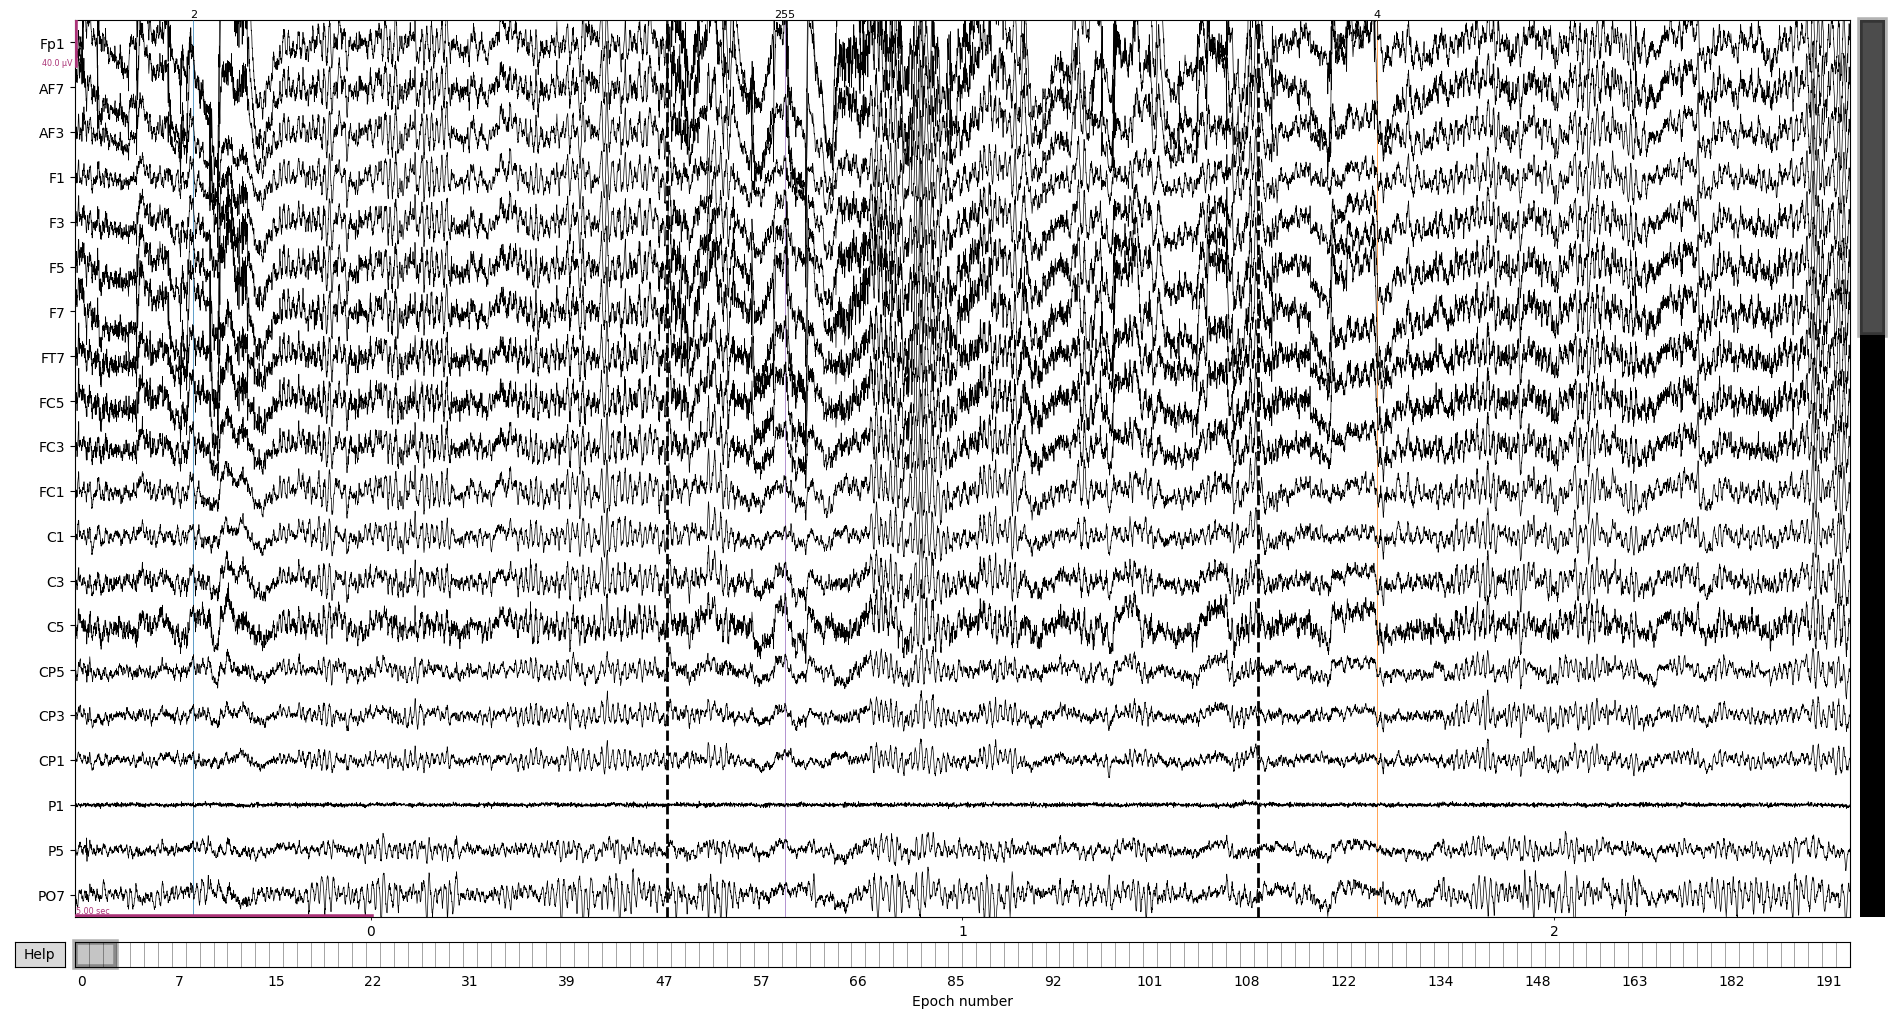

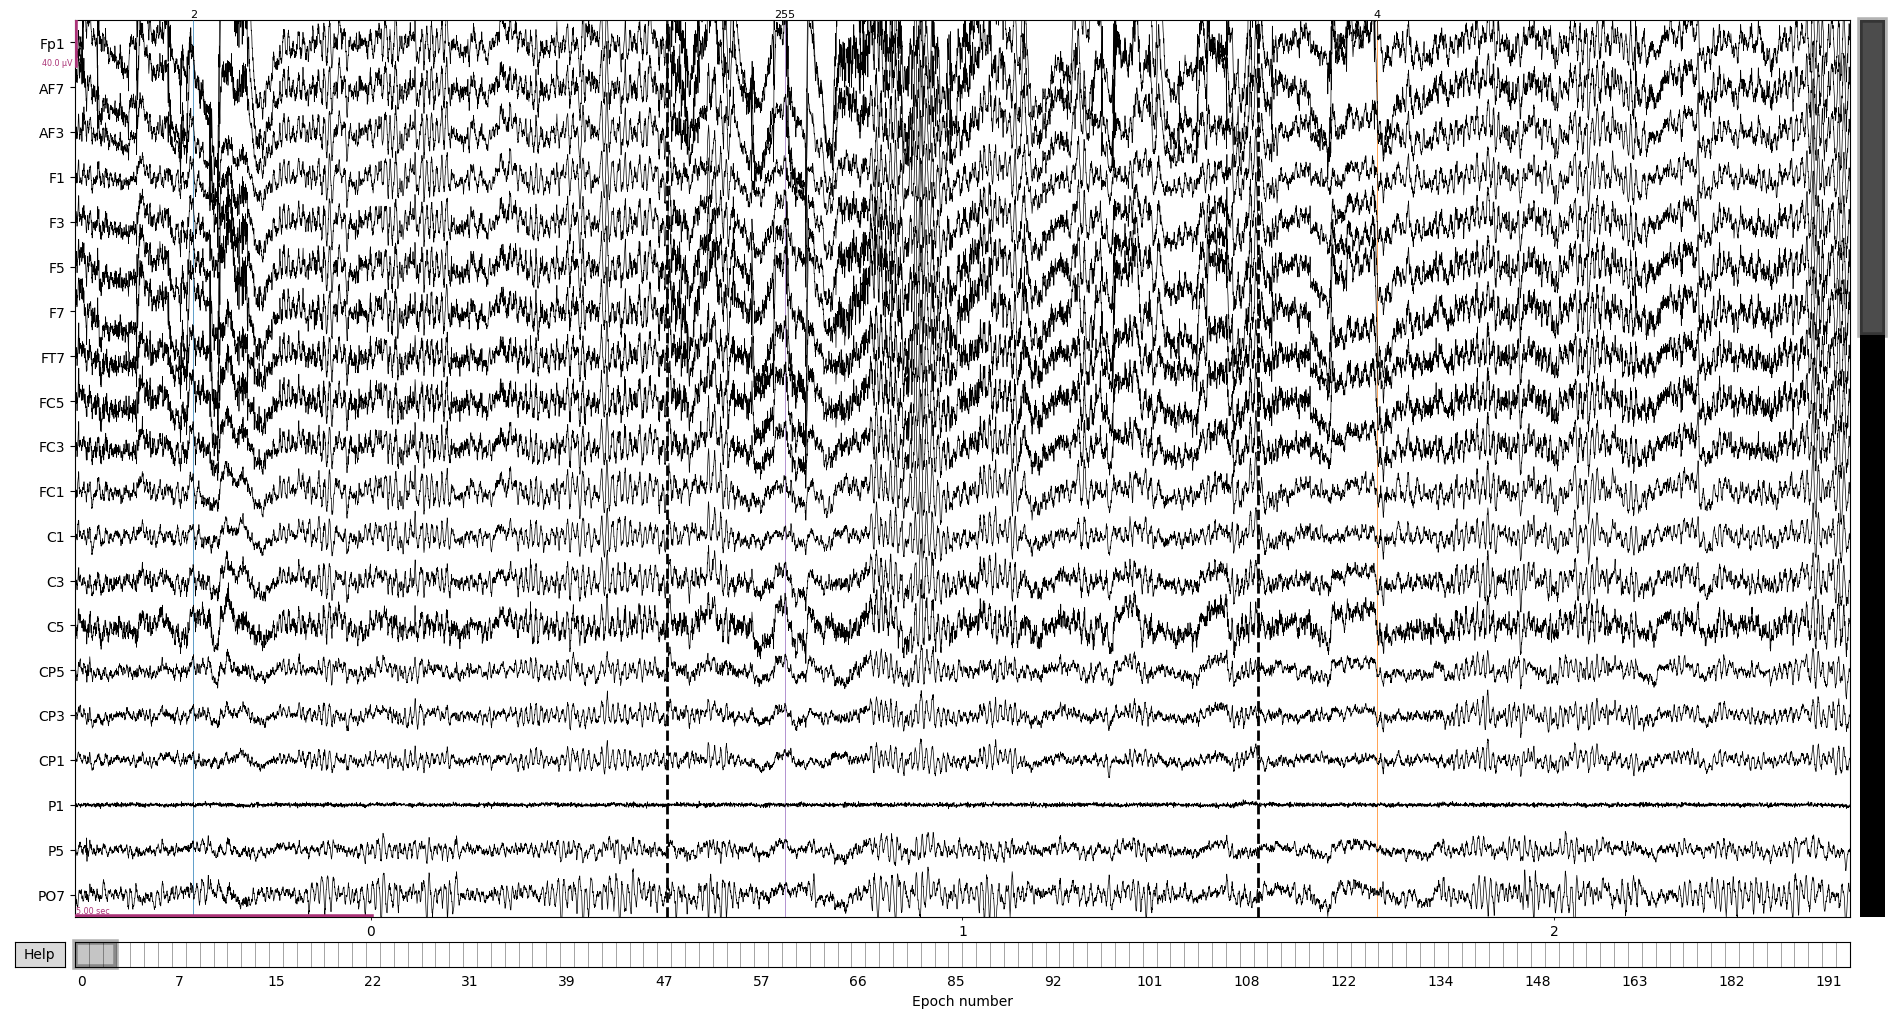

In [17]:
raw.copy().filter(1,120, n_jobs=4).plot(n_channels=20, n_epochs=3, scalings=30e-6, events=epochs.events, event_id=epochs.event_id)

Marking bad chanels

In [25]:
bads = ['T8', 'AF7', 'TP7', 'EXG5', 'EXG7', 'Fpz', 'T7', 'FC6']
raw.info['bads'] = bads
raw.drop([3, 8, 23, 25, 27, 35, 39, 41, 56, 65, 66, 68, 71, 72, 84, 82 ,89,91])

Dropped 18 epochs: 3, 8, 23, 25, 27, 35, 39, 41, 56, 65, 66, 68, 71, 72, 82, 84, 89, 91


<EpochsFIF |  86 events (all good), -2 - 7.99902 sec, baseline off, ~490.6 MB, data loaded,
 'r_pinch': 16
 'r_stop': 16
 'left': 18
 'right': 18
 'rest': 18>

Referencing

In [26]:
referenced = set_eeg_reference(raw, ref_channels='average')[0]
del raw

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Set channel types

In [27]:
referenced.set_channel_types(get_channel_types())

<EpochsFIF |  86 events (all good), -2 - 7.99902 sec, baseline off, ~490.6 MB, data loaded,
 'r_pinch': 16
 'r_stop': 16
 'left': 18
 'right': 18
 'rest': 18>

Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 2060 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 5960 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done 6016 out of 6016 | elapsed:    7.1s finished


Using matplotlib as 2D backend.


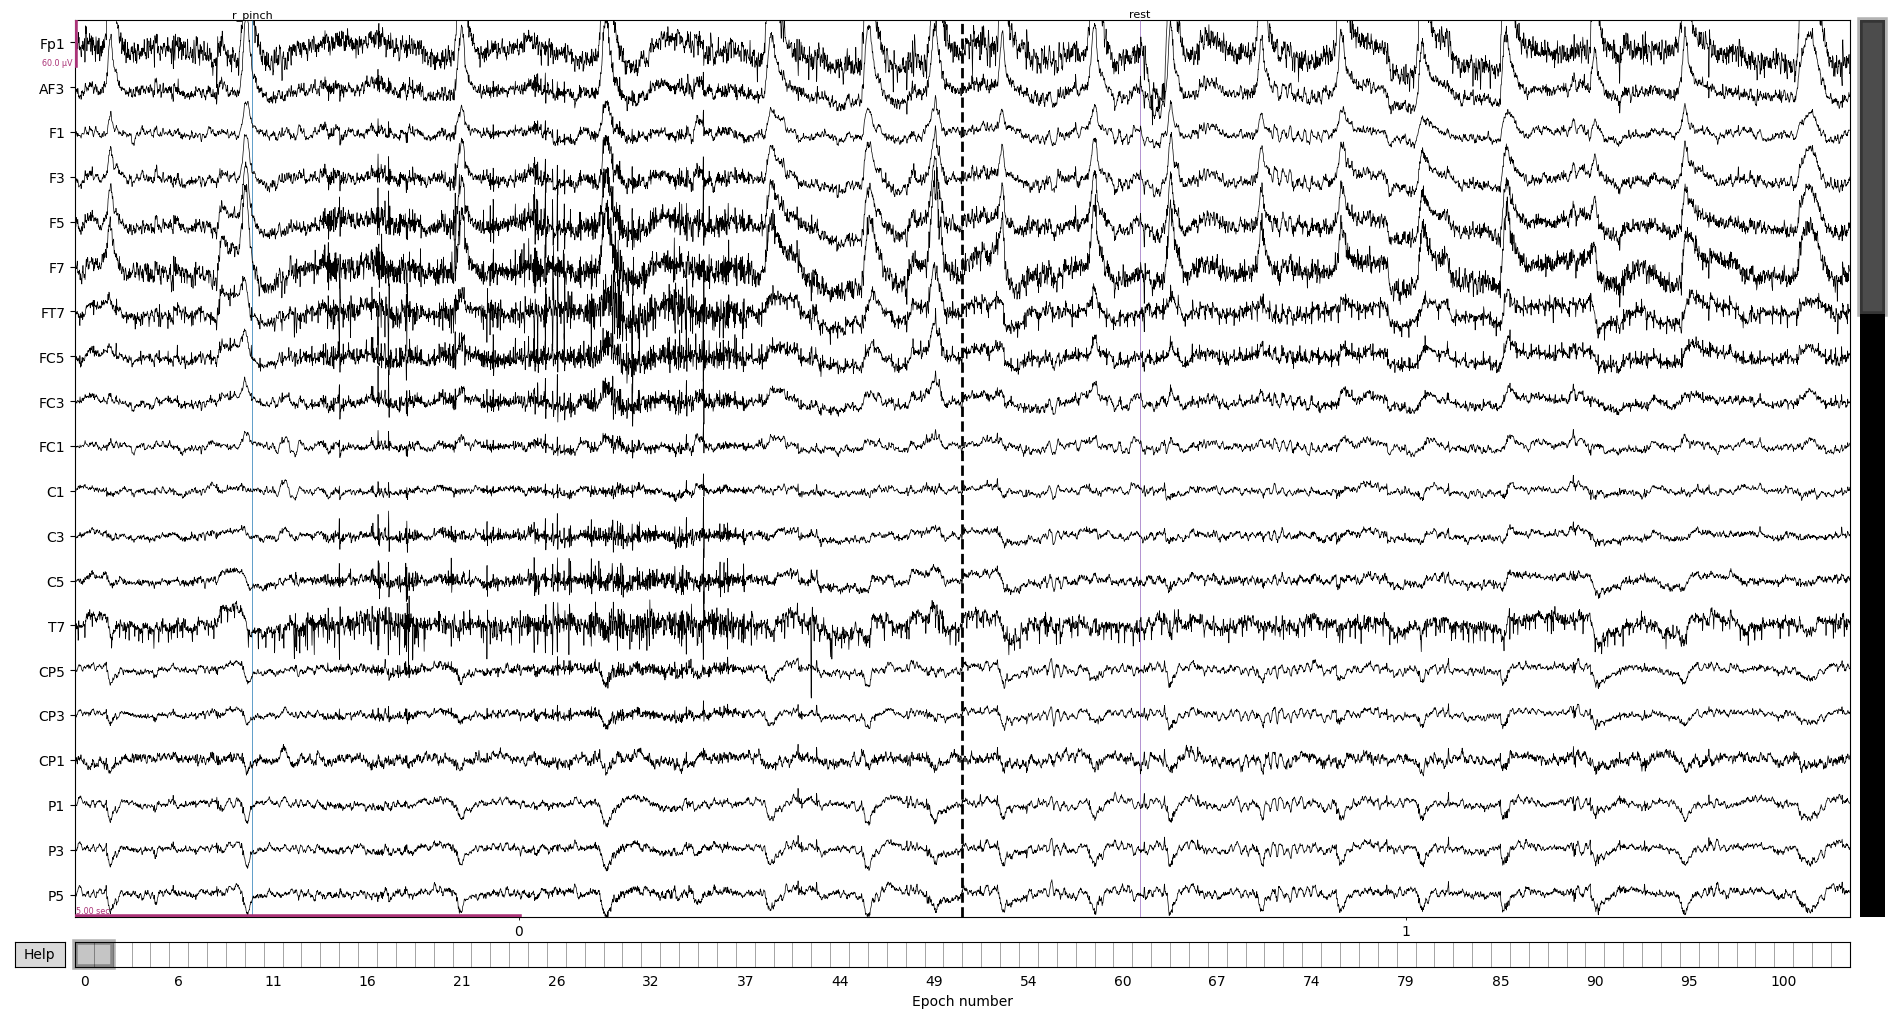

In [16]:
referenced.copy().filter(1,120, n_jobs=4).plot(n_channels=20, n_epochs=2, scalings=30e-6, events=referenced.events, event_id=referenced.event_id)
print()

EOG Regression


No projector specified for this dataset. Please consider the method self.add_proj.


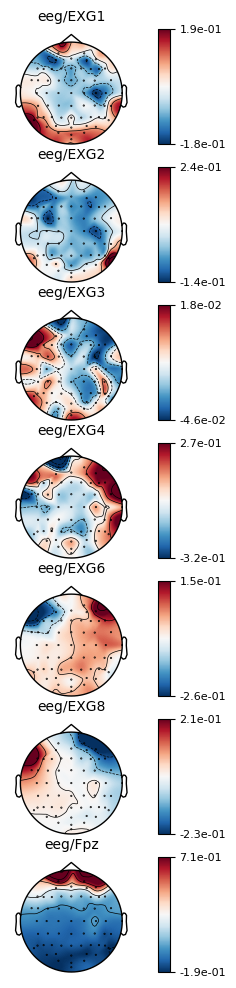

No projector specified for this dataset. Please consider the method self.add_proj.


In [28]:
print()
emg_eog = ['EXG1','EXG2','EXG3','EXG4','EXG6','EXG8','Fpz']
regressor = EOGRegression(
    picks='eeg', picks_artifact= emg_eog).fit(referenced)
regressor.plot()
referenced = regressor.apply(referenced)
referenced.info['bads'] += ['Fpz']

In [29]:
referenced.save('referenced_epo.fif', overwrite=True)
del referenced

Overwriting existing file.


REMOVE ARTIFACTS


In [30]:
epochs = read_epochs('referenced_epo.fif')
epochs

Reading C:\Users\Alberto\Documents\BCI\data\esn\referenced_epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    7999.02 ms
        0 CTF compensation matrices available
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated


<EpochsFIF |  86 events (all good), -2 - 7.99902 sec, baseline off, ~490.6 MB, data loaded,
 'r_pinch': 16
 'r_stop': 16
 'left': 18
 'right': 18
 'rest': 18>


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\Users\Alberto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


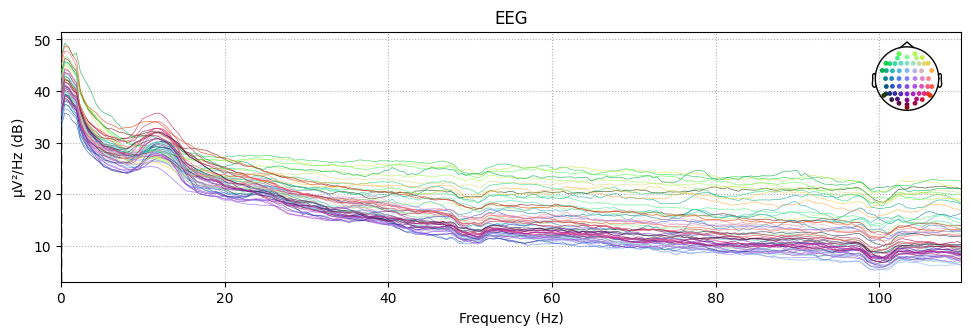

In [31]:
print()
epochs['right','left'].copy().crop(-1,2).plot_psd(fmax=110, tmin=-.1, tmax=2)

ICA

In [32]:
filtered = epochs['rest','left','right'].copy().filter(1,250, n_jobs=8)
filtered.apply_baseline((-1.5,-0.1))
filtered.crop(-1,1.8)
ica = ICA(n_components=10, method='picard')
ica.fit(filtered)

Setting up band-pass filter from 1 - 2.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 250.00 Hz
- Upper transition bandwidth: 62.50 Hz (-6 dB cutoff frequency: 281.25 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 520 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 3280 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done 3456 out of 3456 | elapsed:    5.7s finished


Applying baseline correction (mode: mean)
Fitting ICA to data using 58 channels (please be patient, this may take a while)


C:\Users\Alberto\AppData\Local\Temp\ipykernel_12676\395878811.py:5: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(filtered)


Selecting by number: 10 components
Fitting ICA took 6.7s.


<ICA | epochs decomposition, method: picard (fit in 45 iterations on 154872 samples), 10 ICA components (58 PCA components available), channel types: eeg, no sources marked for exclusion>

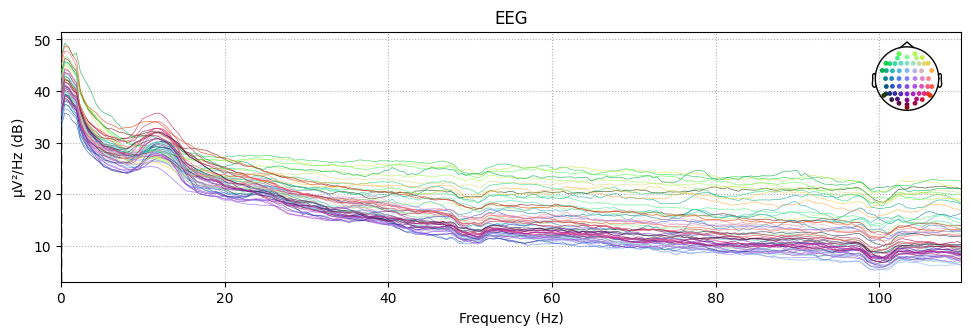

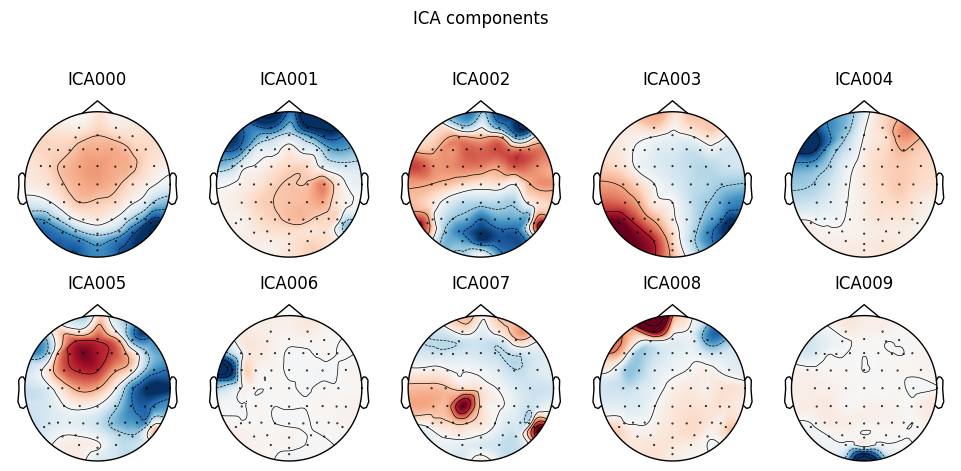

[<MNEFigure size 975x496 with 10 Axes>]

In [33]:
print()
plot_ica_components(ica)


C:\Users\Alberto\AppData\Local\Temp\ipykernel_12676\985191191.py:2: RuntimeWarning: filter_length (3381) is longer than the signal (2356), distortion is likely. Reduce filter length or filter a longer signal.
  epochs['left','right','rest'].copy().crop(-0.5,1.8).filter(1,120, verbose=False),


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
54 matching events found
No baseline correction applied
0 projection i

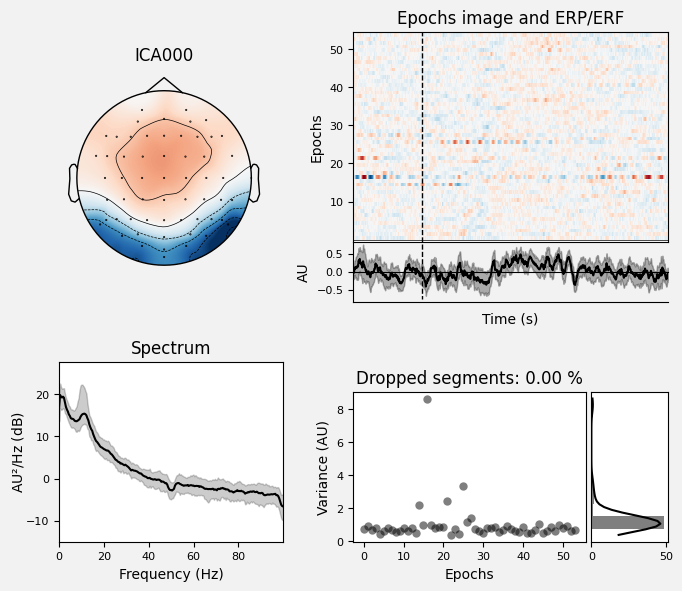

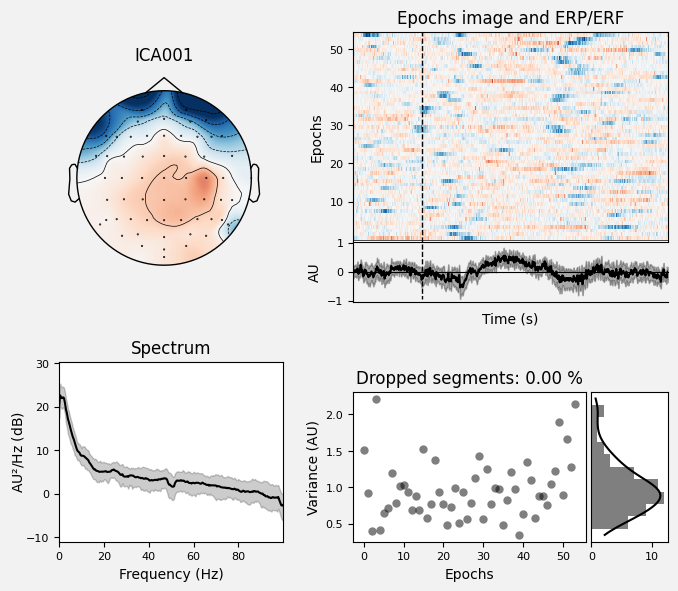

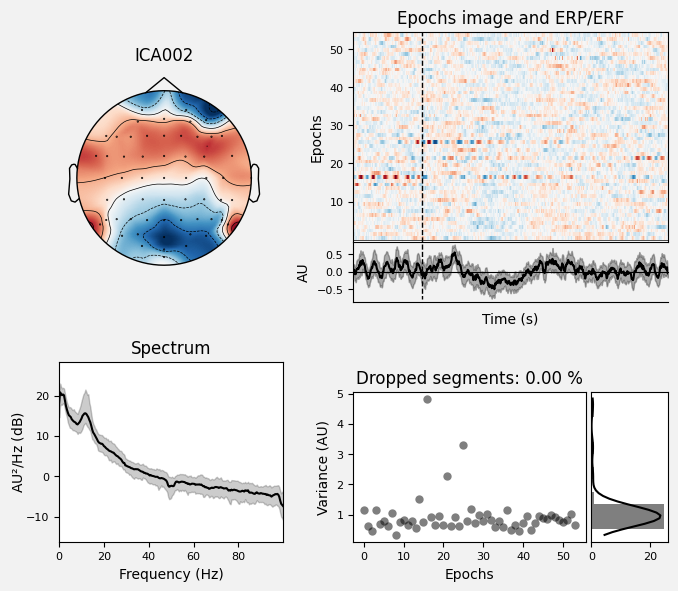

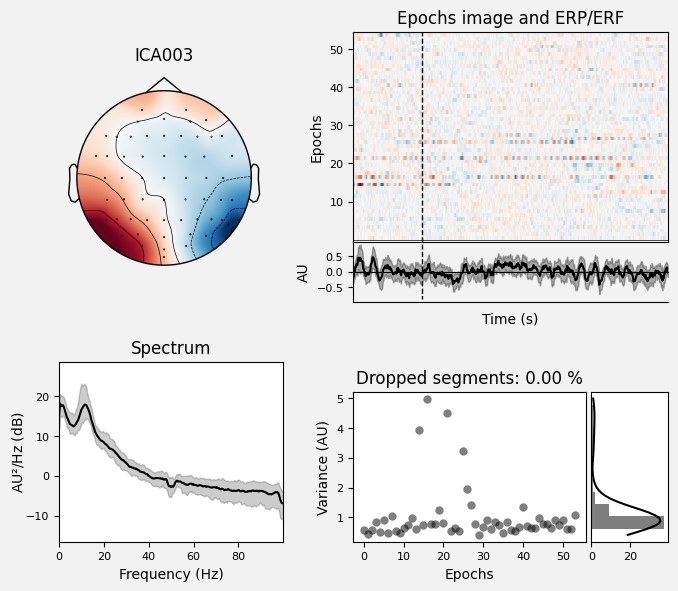

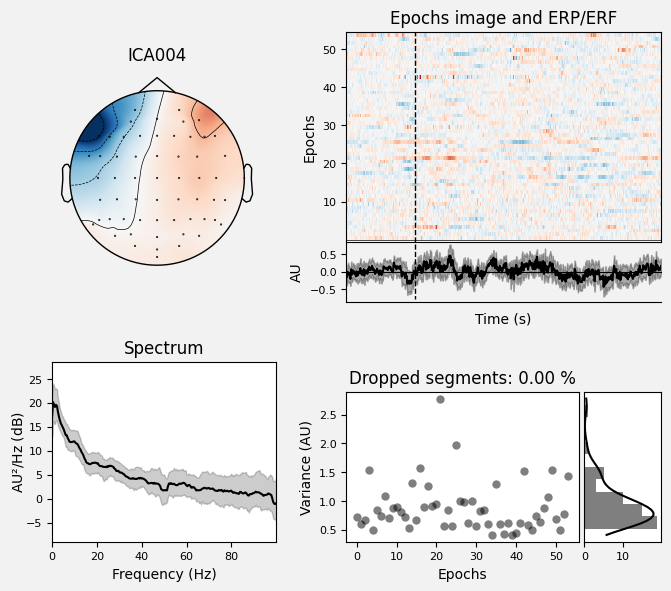

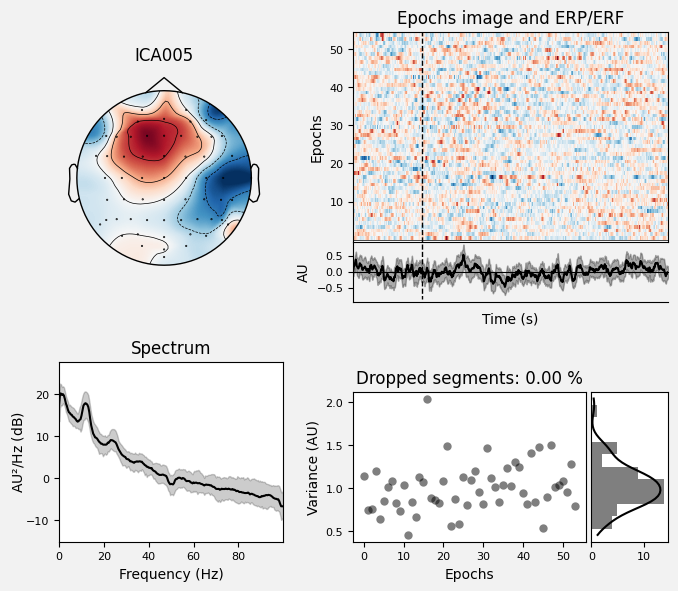

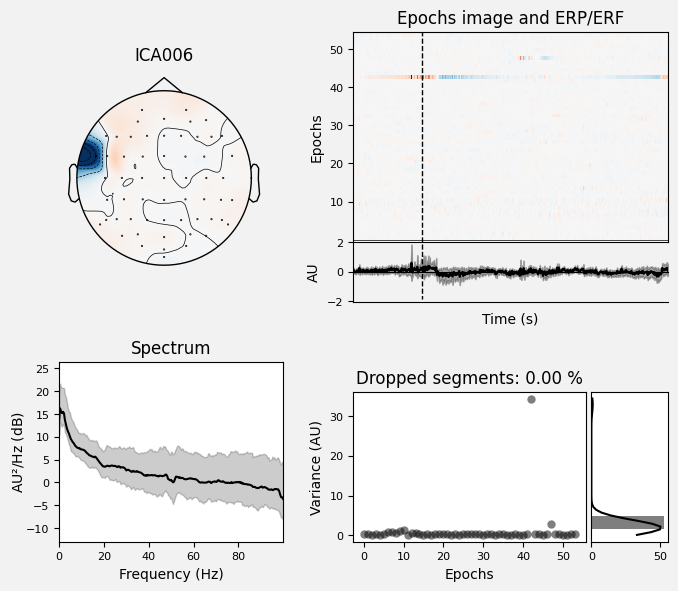

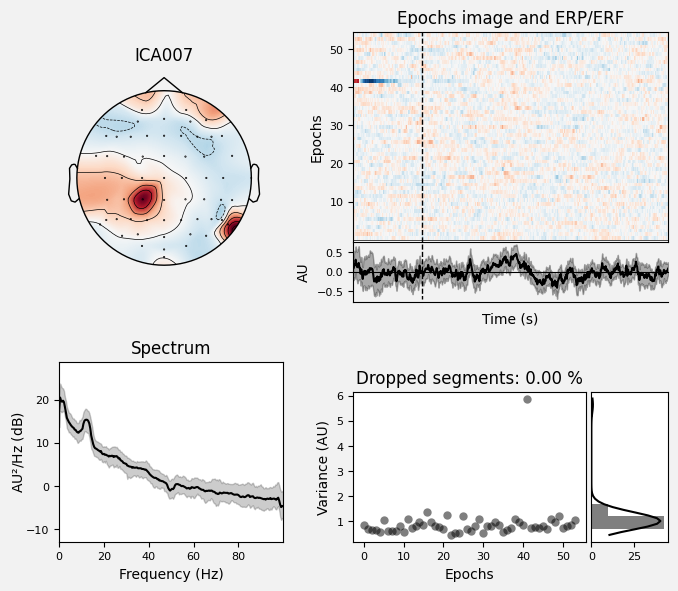

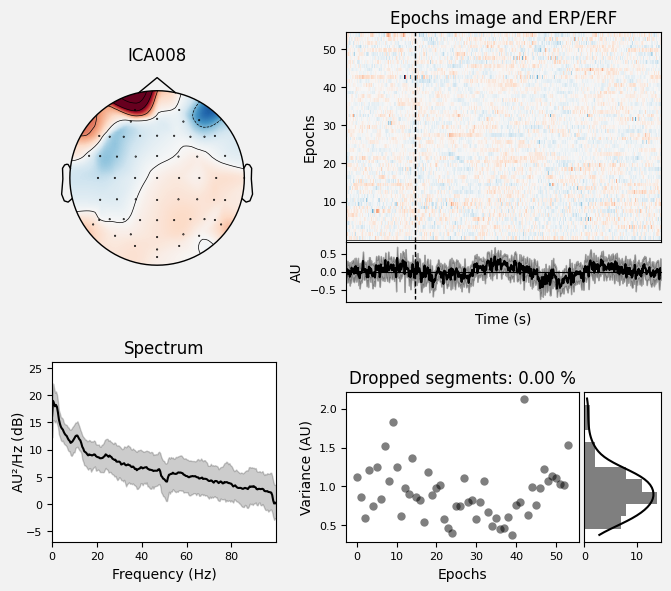

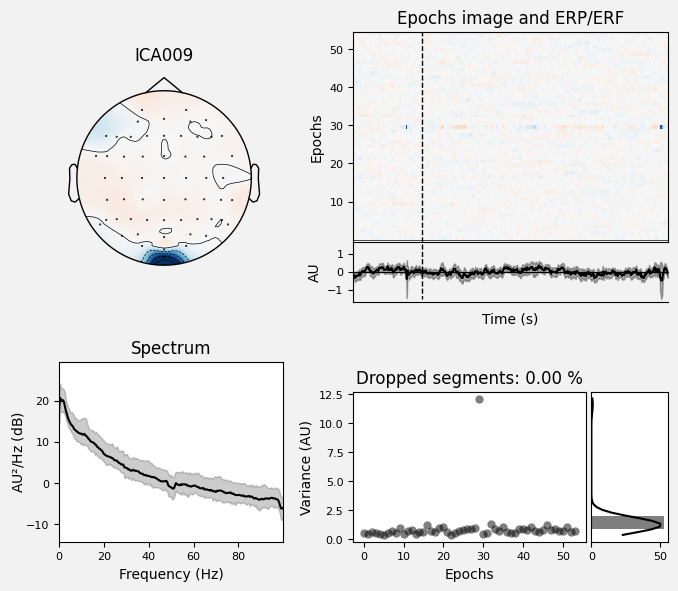

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [37]:
ica.plot_properties(
    epochs['left','right','rest'].copy().crop(-0.5,1.8).filter(1,120, verbose=False), 
    picks = [0,1,2,3,4,5,6,7,8,9], 
    log_scale = False,
    psd_args = dict(fmax=100))

In [35]:
eog_indices, eog_scores = ica.find_bads_eog(
    filtered['left','right','rest'],
    ch_name= emg_eog, 
    measure='zscore',
    threshold=2.)


Using EOG channels: EXG1, EXG2, EXG3, EXG4, EXG6, EXG8, Fpz


In [36]:
eog_indices


[1, 4, 5]

In [38]:
ica.apply(epochs, exclude= [1,4,6,8])

Applying ICA to Epochs instance
    Transforming to ICA space (10 components)
    Zeroing out 4 ICA components
    Projecting back using 58 PCA components


<EpochsFIF |  86 events (all good), -2 - 7.99902 sec, baseline off, ~490.6 MB, data loaded,
 'r_pinch': 16
 'r_stop': 16
 'left': 18
 'right': 18
 'rest': 18>

ERP

Setting up band-pass filter from 1 - 2.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 250.00 Hz
- Upper transition bandwidth: 62.50 Hz (-6 dB cutoff frequency: 281.25 Hz)
- Filter length: 3381 samples (3.302 sec)



C:\Users\Alberto\AppData\Local\Temp\ipykernel_12676\2041666621.py:1: RuntimeWarning: filter_length (3381) is longer than the signal (2561), distortion is likely. Reduce filter length or filter a longer signal.
  epochs['left','right'].copy().crop(-0.5,2).filter(1,250, n_jobs=8).average().plot()
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1540 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 2304 out of 2304 | elapsed:    0.9s finished


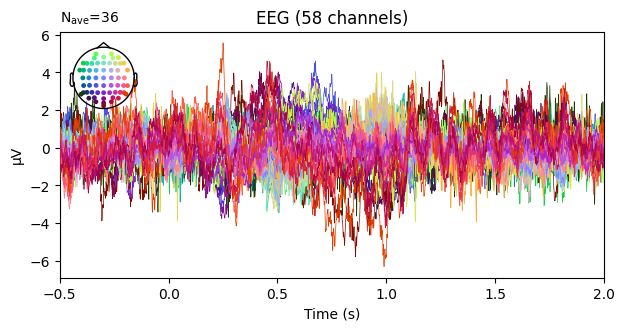

In [39]:
epochs['left','right'].copy().crop(-0.5,2).filter(1,250, n_jobs=8).average().plot()
print()

Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 3381 samples (3.302 sec)



C:\Users\Alberto\AppData\Local\Temp\ipykernel_12676\2447180343.py:1: RuntimeWarning: filter_length (3381) is longer than the signal (2561), distortion is likely. Reduce filter length or filter a longer signal.
  epochs['rest'].copy().crop(-0.5,2).filter(1,120, n_jobs=8).average().plot()
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 835 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1152 out of 1152 | elapsed:    0.6s finished


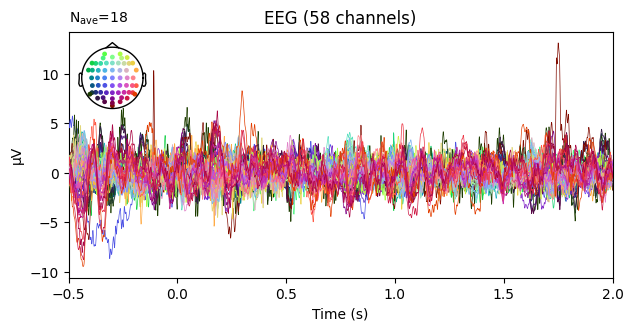

In [40]:
epochs['rest'].copy().crop(-0.5,2).filter(1,120, n_jobs=8).average().plot()
print()

CSP 

In [41]:
le = LabelEncoder()
subset = epochs['left','rest'].copy()
subset.apply_baseline((-1.,-0.1))
subset.drop_channels(epochs.info['bads'])
subset = subset.pick(['eeg'])
y = le.fit_transform(subset.events[:,2])

Applying baseline correction (mode: mean)


In [42]:
pca = UnsupervisedSpatialFilter(PCA(len(subset.info['chs'])), average=False)
csp = CSP(n_components=2, reg=None, log=True, norm_trace=False, rank='info')
x = pca.fit_transform(subset.copy().crop(-0.1,2).filter(5, 20, n_jobs=4, verbose=False).get_data(),y)

Computing rank from data with rank='info'
    MAG: rank 58 after 0 projectors applied to 58 channels
Reducing data rank from 58 -> 58
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 58 after 0 projectors applied to 58 channels
Reducing data rank from 58 -> 58
Estimating covariance using EMPIRICAL
Done.


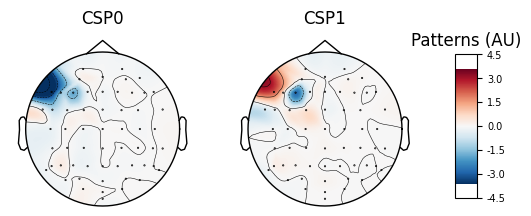

In [43]:
x = pca.fit_transform(subset.copy().crop(-0.1,2).filter(5, 20, n_jobs=4, verbose=False).get_data(),y)
csp.fit(x,y)
csp.plot_patterns(subset.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
print()

Computing rank from data with rank='info'
    MAG: rank 58 after 0 projectors applied to 58 channels
Reducing data rank from 58 -> 58
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 58 after 0 projectors applied to 58 channels
Reducing data rank from 58 -> 58
Estimating covariance using EMPIRICAL
Done.


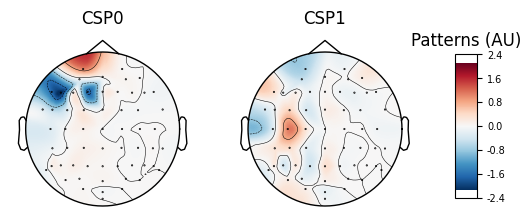

In [44]:
x = pca.fit_transform(subset.copy().crop(-0.1,2).filter(20, 35, n_jobs=4, verbose=False).get_data(),y)
csp.fit(x,y)
csp.plot_patterns(subset.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
print()

Computing rank from data with rank='info'
    MAG: rank 58 after 0 projectors applied to 58 channels
Reducing data rank from 58 -> 58
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 58 after 0 projectors applied to 58 channels
Reducing data rank from 58 -> 58
Estimating covariance using EMPIRICAL
Done.


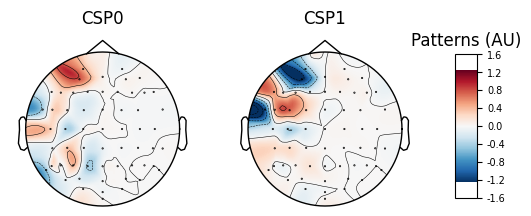

In [45]:
x = pca.fit_transform(subset.copy().crop(-0.1,1.8).filter(70, 90, n_jobs=4, verbose=False).get_data(),y)
csp.fit(x,y)
csp.plot_patterns(subset.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
print()

In [46]:
epochs.save('ica_epo.fif', overwrite=True)

Overwriting existing file.
